# Demo: mooring-level processing (Step 1)

This notebook demonstrates the first of the mooring-level processing steps, time_gridding.



## Step 1: Time Gridding and Optional Filtering Demo

This notebook demonstrates the Step 1 processing workflow for mooring data:
- Loading multiple instrument datasets
- Optional time-domain filtering (applied BEFORE interpolation)
- Interpolating onto a common time grid
- Combining into a unified mooring dataset

**Key Point**: Filtering is applied to individual instrument records on their native time grids BEFORE interpolation to preserve data integrity.

Version: 1.0  
Date: 2025-09-07

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

# Import the time gridding module
from oceanarray.time_gridding import (
    TimeGriddingProcessor,
    time_gridding_mooring,
    process_multiple_moorings_time_gridding
)

# Set up plotting
plt.style.use('default')


### Configuration

First, let's set up our data paths and examine the mooring configuration.

In [2]:
# Set your data paths here
basedir = '../data'
mooring_name = 'dsE_1_2018'

# Construct paths
proc_dir = Path(basedir) / 'moor' / 'proc' / mooring_name
config_file = proc_dir / f"{mooring_name}.mooring.yaml"

print(f"Processing directory: {proc_dir}")
print(f"Configuration file: {config_file}")
print(f"Config exists: {config_file.exists()}")

Processing directory: ../data/moor/proc/dsE_1_2018
Configuration file: ../data/moor/proc/dsE_1_2018/dsE_1_2018.mooring.yaml
Config exists: True


In [3]:
# Load and examine the mooring configuration
if config_file.exists():
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)

    print("Mooring Configuration:")
    print(f"Name: {config['name']}")
    print(f"Water depth: {config.get('waterdepth', 'unknown')} m")
    print(f"Location: {config.get('latitude', 'unknown')}°N, {config.get('longitude', 'unknown')}°E")
    print(f"\nInstruments ({len(config.get('instruments', []))}):")

    for i, inst in enumerate(config.get('instruments', [])):
        print(f"  {i+1}. {inst.get('instrument', 'unknown')} "
              f"(serial: {inst.get('serial num.', 'unknown')}) at {inst.get('depth', 'unknown')} m")
else:
    print("Configuration file not found!")
    print("Please check your data path and mooring name.")

Mooring Configuration:
Name: dsE_1_2018
Water depth: 929 m
Location: 65.47561666666667°N, -29.570083333333333°E

Instruments (23):
  1. sbe56 (serial: unknown) at 629 m
  2. sbe16 (serial: unknown) at 679 m
  3. sbe56 (serial: unknown) at 689 m
  4. sbe56 (serial: unknown) at 699 m
  5. sbe56 (serial: unknown) at 709 m
  6. sbe56 (serial: unknown) at 719 m
  7. sbe56 (serial: unknown) at 729 m
  8. sbe56 (serial: unknown) at 739 m
  9. sbe56 (serial: unknown) at 749 m
  10. sbe56 (serial: unknown) at 759 m
  11. sbe56 (serial: unknown) at 769 m
  12. sbe16 (serial: unknown) at 780 m
  13. tr1050 (serial: unknown) at 790 m
  14. rbrsolo (serial: unknown) at 800 m
  15. tr1050 (serial: unknown) at 810 m
  16. rbrsolo (serial: unknown) at 820 m
  17. tr1050 (serial: unknown) at 830 m
  18. rbrsolo (serial: unknown) at 840 m
  19. tr1050 (serial: unknown) at 850 m
  20. rbrsolo (serial: unknown) at 860 m
  21. tr1050 (serial: unknown) at 870 m
  22. microcat (serial: unknown) at 880 m
  23

### Examine individual instrument files

Let's look at the individual instrument files before processing to understand the different sampling rates and data characteristics.

In [4]:
# Find and examine individual instrument files
file_suffix = "_use"
instrument_files = []
instrument_datasets = []
rows = []

if config_file.exists():
    for inst_config in config.get("instruments", []):
        instrument_type = inst_config.get("instrument", "unknown")
        serial = inst_config.get("serial", 0)
        depth = inst_config.get("depth", 0)

        # Look for the file
        filename = f"{mooring_name}_{serial}{file_suffix}.nc"
        filepath = proc_dir / instrument_type / filename

        if filepath.exists():
            ds = xr.open_dataset(filepath)
            instrument_files.append(filepath)
            instrument_datasets.append(ds)

            # Time coverage
            t0, t1 = ds.time.values[0], ds.time.values[-1]
            npoints = len(ds.time)

            # Median sampling interval
            time_diff = np.diff(ds.time.values) / np.timedelta64(1, "m")  # in minutes
            median_interval = np.nanmedian(time_diff)
            if median_interval > 1:
                sampling = f"{median_interval:.1f} min"
            else:
                sampling = f"{median_interval*60:.1f} sec"

            # Collect a row for the table
            rows.append(
                {
                    "Instrument": instrument_type,
                    "Serial": serial,
                    "Depth [m]": depth,
                    "File": filepath.name,
                    "Start": str(t0)[:19],
                    "End": str(t1)[:19],
                    "Points": npoints,
                    "Sampling": sampling,
                    "Variables": ", ".join(list(ds.data_vars)),
                }
            )
        else:
            rows.append(
                {
                    "Instrument": instrument_type,
                    "Serial": serial,
                    "Depth [m]": depth,
                    "File": "MISSING",
                    "Start": "",
                    "End": "",
                    "Points": 0,
                    "Sampling": "",
                    "Variables": "",
                }
            )

    # Make a DataFrame summary
    summary = pd.DataFrame(rows)
    pd.set_option("display.max_colwidth", 80)  # allow long var lists
    print(summary.to_markdown(index=False))

    print(f"\nFound {len(instrument_datasets)} instrument datasets")


| Instrument   |   Serial |   Depth [m] | File                   | Start               | End                 |   Points | Sampling   | Variables                                                                                                                |
|:-------------|---------:|------------:|:-----------------------|:--------------------|:--------------------|---------:|:-----------|:-------------------------------------------------------------------------------------------------------------------------|
| sbe56        |     6363 |         629 | MISSING                |                     |                     |        0 |            |                                                                                                                          |
| sbe16        |     2419 |         679 | MISSING                |                     |                     |        0 |            |                                                                                            

### Process with time gridding (no filtering)

In [5]:
# Process without filtering
print("Processing mooring with time gridding only (no filtering)...")
print("="*60)

result = time_gridding_mooring(mooring_name, basedir, file_suffix='_use')

print(f"\nProcessing result: {'SUCCESS' if result else 'FAILED'}")

Processing mooring with time gridding only (no filtering)...
Starting Step 1 (time gridding) processing for mooring: dsE_1_2018
Using files with suffix: _use
Loading microcat serial 7518: dsE_1_2018_7518_use.nc

   - sbe56:6363
   - sbe16:2419
   - sbe56:6401
   - sbe56:6402
   - sbe56:8482
   - sbe56:6365
   - sbe56:6409
   - sbe56:6397
   - sbe56:6366
   - sbe56:6394
   - sbe56:6370
   - sbe16:2418
   - tr1050:13889
   - rbrsolo:101651
   - tr1050:15580
   - rbrsolo:101647
   - tr1050:13874
   - rbrsolo:101645
   - tr1050:15574
   - rbrsolo:101646
   - tr1050:15577
   - sbe56:6364
   Expected 23, found 1

Loaded 1 instrument datasets
Dataset 0 depth 880 [microcat:7518]:
  Start: 2018-08-13T07:25:51, End: 2018-08-26T10:37:50
  Time interval - Median: 10.02 sec, Range: 9.94 sec to 10.02 sec, Std: 0.04 sec
  Variables: ['temperature', 'salinity', 'conductivity', 'pressure', 'serial_number', 'InstrDepth', 'instrument', 'clock_offset', 'start_time', 'end_time']

TIMING ANALYSIS:
   Overal

Successfully interpolated dataset 0
Variable 'u_velocity' not found in any dataset, skipping
Variable 'v_velocity' not found in any dataset, skipping
Successfully wrote time-gridded dataset: ../data/moor/proc/dsE_1_2018/dsE_1_2018_mooring_use.nc
Combined dataset shape: {'time': 113472, 'N_LEVELS': 1}
Variables: ['temperature', 'salinity', 'conductivity', 'pressure', 'instrument_id']

Processing result: SUCCESS


In [6]:
# Load and examine the combined dataset
output_file = proc_dir / f"{mooring_name}_mooring_use.nc"

if output_file.exists():
    print(f"Output file exists: {output_file}")

    # Load the combined dataset
    combined_ds = xr.open_dataset(output_file)
else:
    print("Output file not found - processing may have failed")

Output file exists: ../data/moor/proc/dsE_1_2018/dsE_1_2018_mooring_use.nc


### Visualize Combined Dataset

Let's plot the combined dataset to see how the different instruments look on the common time grid.


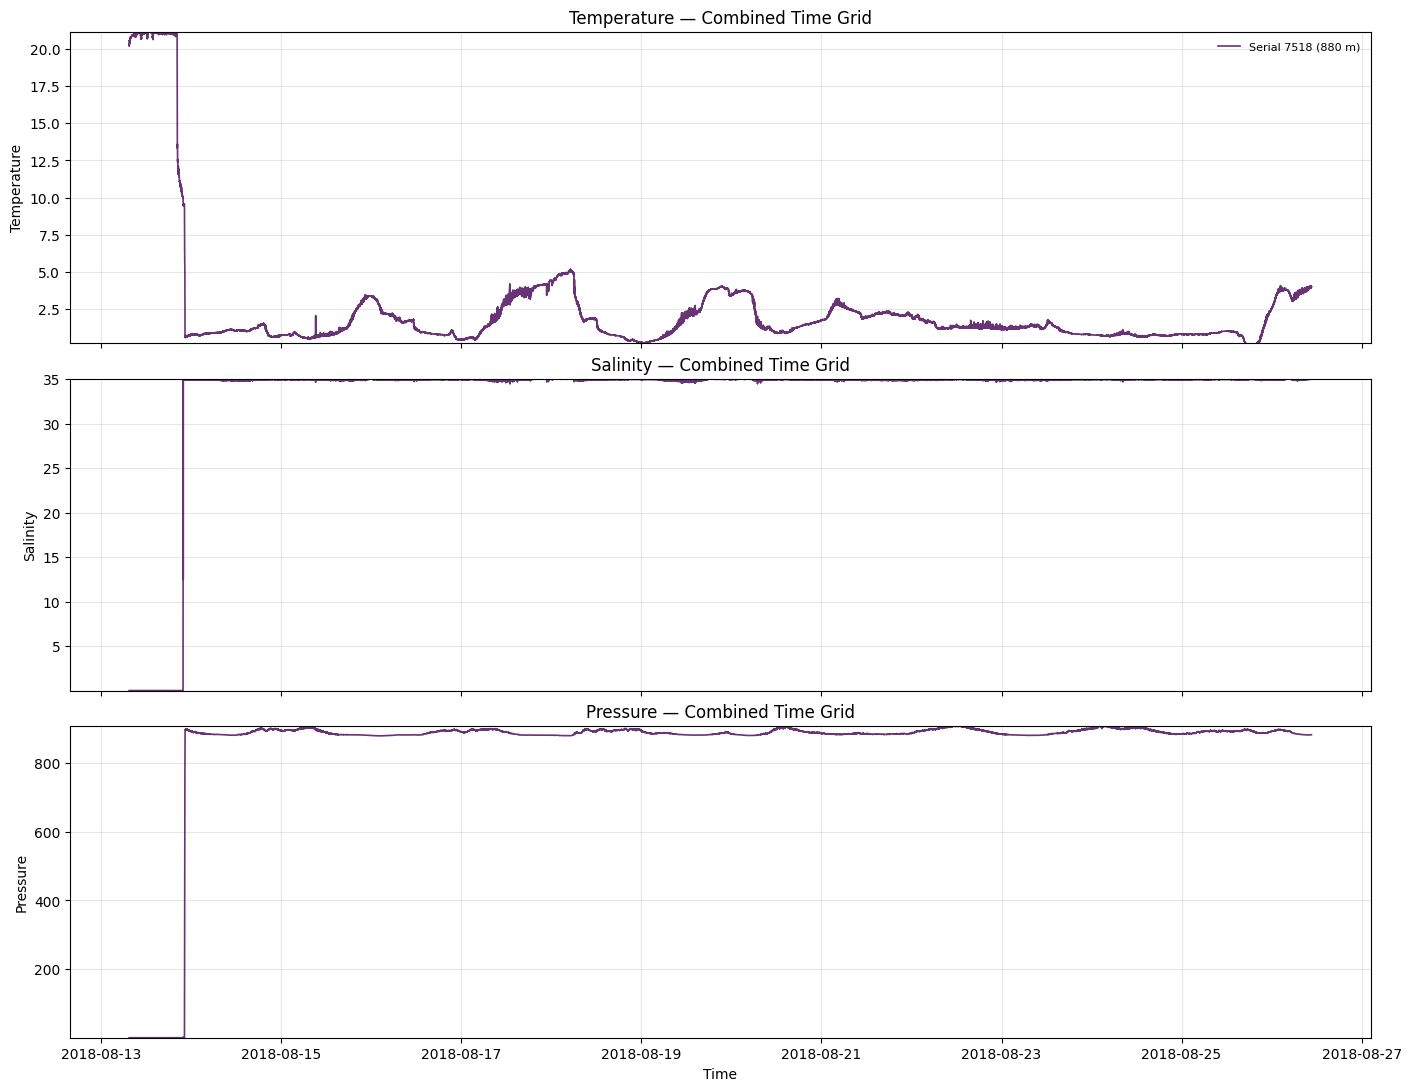

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_combined_timeseries(
    combined_ds,
    variables=("temperature", "salinity", "pressure"),
    cmap_name="viridis",
    line_alpha=0.8,
    line_width=1.2,
    percentile_limits=(1, 99),
):
    """
    Plot selected variables from a combined mooring dataset as stacked time series.

    Parameters
    ----------
    combined_ds : xarray.Dataset
        Must have dims: time, N_LEVELS. Optional coords: nominal_depth, serial_number.
    variables : iterable[str]
        Variable names to try to plot (if present in dataset).
    cmap_name : str
        Matplotlib colormap name for coloring by instrument level.
    line_alpha : float
        Line transparency.
    line_width : float
        Line width.
    percentile_limits : (low, high)
        Percentiles to use for automatic y-limits (e.g., (1, 99)).
    """
    if combined_ds is None:
        print("Combined dataset not available.")
        return None, None
    n_levels = combined_ds.sizes.get("N_LEVELS")
    if n_levels is None:
        raise ValueError("Dataset must contain dimension 'N_LEVELS'.")

    available = [v for v in variables if v in combined_ds.data_vars]
    if not available:
        print("No requested variables found to plot.")
        return None, None

    # Colors by level
    cmap = plt.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, n_levels))

    fig, axes = plt.subplots(
        len(available), 1, figsize=(14, 3.6 * len(available)), sharex=True, constrained_layout=True
    )
    if len(available) == 1:
        axes = [axes]

    depth_arr = combined_ds.get("nominal_depth")
    serial_arr = combined_ds.get("serial_number")

    first_axis = True
    for ax, var in zip(axes, available):
        values_for_limits = []
        for level in range(n_levels):
            depth = None if depth_arr is None else depth_arr.values[level]
            serial = None if serial_arr is None else serial_arr.values[level]
            label = None
            if first_axis:
                if depth is not None and np.isfinite(depth):
                    label = f"Serial {serial} ({int(depth)} m)" if serial is not None else f"({int(depth)} m)"
                elif serial is not None:
                    label = f"Serial {serial}"

            da = combined_ds[var].isel(N_LEVELS=level)
            da = da.where(np.isfinite(da), drop=True)
            if da.size == 0:
                continue

            values_for_limits.append(da.values)

            ax.plot(
                da["time"].values,
                da.values,
                color=colors[level],
                alpha=line_alpha,
                linewidth=line_width,
                label=label,
            )

        # Set labels and grid
        ax.set_ylabel(var.replace("_", " ").title())
        ax.grid(True, alpha=0.3)
        ax.set_title(f"{var.replace('_', ' ').title()} — Combined Time Grid")

        # Legend only once
        if first_axis:
            ax.legend(ncol=3, fontsize=8, loc="upper right", frameon=False)
            first_axis = False

        # Auto y-limits based on percentiles
        if values_for_limits:
            flat = np.concatenate(values_for_limits)
            low, high = np.nanpercentile(flat, percentile_limits)
            ax.set_ylim(low, high)

    axes[-1].set_xlabel("Time")
    return fig, axes

# Usage:
if 'combined_ds' in locals():
    plot_combined_timeseries(combined_ds)
